In [1]:
import cococo.layouts as layouts
import cococo.utils_routing as utils
import cococo.hill_climber as hill_climber
import cococo.circuit_construction as circuit_construction
import cococo.internal_testing as internal_testing
import plotting

## Sample Run for Hill Climbing 

#### Choose a layout

In [7]:
#layout_type = "pair"
#m = 3
#n = 4
#factories =[
# (12, 7),
# (14, -1),
# (5, -1),
# (3, 7),]
#remove_edges = False
#g, data_qubit_locs, factory_ring = layouts.gen_layout_scalable(layout_type, m, n, factories, remove_edges)

#t=4

In [8]:
#layout_type = "hex"
#m = 3
#n = 3
#factories = [
#    (4, 9),
#    (7, 10),
#    (18, 9),
#    (10, 0),
#    (-1, -2)
#]
#g, data_qubit_locs, factory_ring = layouts.gen_layout_scalable(layout_type, m, n, factories, remove_edges=False)
#
#t=4

In [9]:
layout_type = "hex"
m = 2
n = 2
factories = [
    (5, -1),
    (10, 0),
    (7, 7),
    (12, 5),
    (-2, 2)
]
g, data_qubit_locs, factory_ring = layouts.gen_layout_scalable(layout_type, m, n, factories, remove_edges=False)
t=4

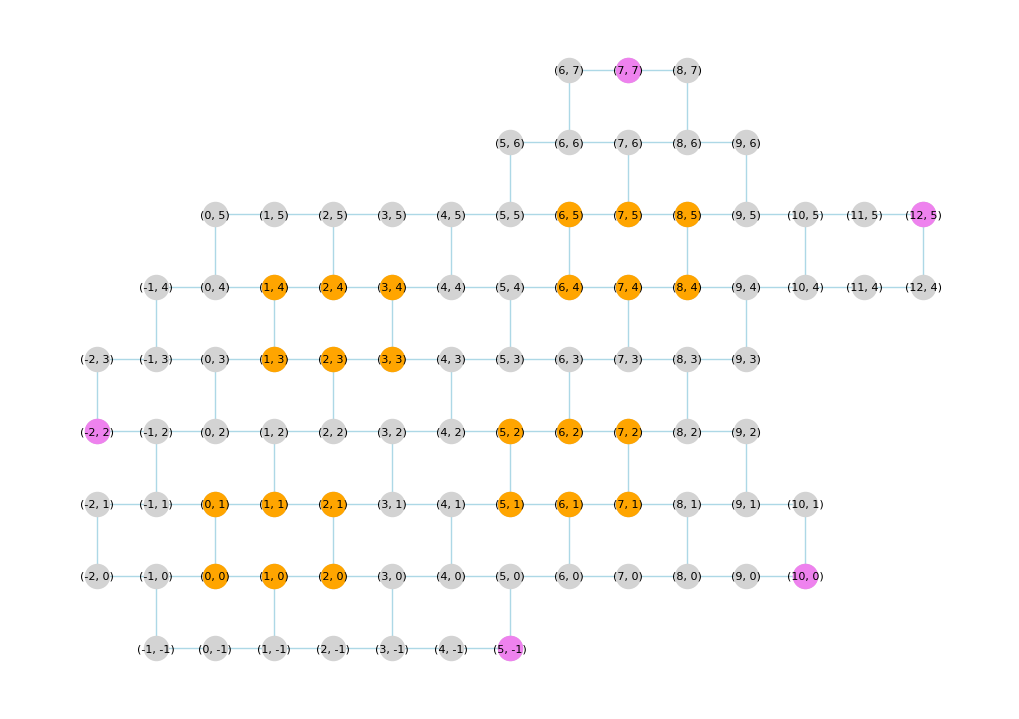

In [10]:
size = (10,7)
plotting.plot_lattice(
    g, size=size, data_qubit_locs=data_qubit_locs, factory_locs=factories
)

### Take the given circuit or sample another

In [6]:
q = len(data_qubit_locs)
#pairs = circuit_construction.generate_random_circuit(q, q, tgate=True, ratio = 0.8)
#print(len(pairs))

In [7]:
pairs = [
    (1, 5),
    0,
    (10, 3),
    (8, 18),
    (13, 2),
    (4, 20),
    (9, 6),
    (11, 23),
    15,
    7,
    (16, 21),
    (22, 23),
    (0, 10),
    (23, 19),
    (10, 12),
    (2, 19),
    (21, 1),
    (13, 4),
    22,
    (14, 13),
    (22, 1),
    (15, 11),
    (22, 20),
    (6, 11),
    (10, 8),
    13,
    19,
    (17, 20)
]

### Run the Hill Climber for the initial mapping

In [24]:
custom_layout = [data_qubit_locs, g]

hc = hill_climber.HillClimbing(
    max_restarts=20,
    max_iterations=50,
    circuit=pairs,
    metric="exact",
    t=t,
    custom_layout=custom_layout,
    use_dag = True,
    valid_path = "cc",
    possible_factory_positions=factories,
    num_factories=len(factories),
    optimize_factories=False,
    
)

parallel = True
processes = 8 #depending on your hardware
prefix = "./" #adapt the path depending on where you want to have stored the output
suffix = "test_hc"
best_solution, best_score, best_rep, score_history = hc.run(prefix, suffix, parallel, processes)
print(f"Best solution: {best_solution}")
print(f"Best score: {best_score}")
print(f"To which repetition of the random restarts does the best score belong? {best_rep}")

Hill Climbing Restarts...: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

Best solution: {20: (0, 0), 3: (1, 0), 5: (1, 3), 18: (0, 1), 6: (1, 1), 21: (2, 1), 14: (5, 1), 17: (6, 1), 22: (7, 1), 11: (5, 2), 12: (6, 2), 4: (7, 2), 1: (2, 0), 16: (2, 3), 7: (3, 3), 19: (1, 4), 0: (2, 4), 10: (3, 4), 9: (6, 4), 2: (7, 4), 23: (8, 4), 15: (6, 5), 13: (7, 5), 8: (8, 5), 'factory_positions': [(5, -1), (12, 5), (-2, 2), (7, 7), (10, 0)]}
Best score: 10
To which repetition of the random restarts does the best score belong? 0


### Run the Standard Routing with a standard layout

In [8]:
#standard layout
layout = {}
for i, j in zip(range(len(data_qubit_locs)), data_qubit_locs):
    layout.update({i: (int(j[0]), int(j[1]))})
terminal_pairs = layouts.translate_layout_circuit(pairs, layout) #let's stick to the simple layout

In [9]:
router = utils.BasicRouter(g, data_qubit_locs, factories, valid_path = "cc", t=t, metric = "exact", use_dag = True)
layers = router.split_layer_terminal_pairs(terminal_pairs)
vdp_layers, _ = router.find_total_vdp_layers_dyn(layers, data_qubit_locs, router.factory_times, layout, testing = True)
print("Len of schedule without mapping optimization: ", len(vdp_layers))

2025-11-15 14:56:18,189 [INFO] root: stim test succeeded for standard routing (:
2025-11-15 14:56:18,190 [INFO] root: no duplicates found in standard routing (:
2025-11-15 14:56:18,190 [INFO] root: paths do not occupy logical pos (:
2025-11-15 14:56:18,190 [INFO] root: Reset times make sense, all good(:
Len of schedule without mapping optimization:  11


### Run the Standard Routing with optimized layout

In [27]:
layout_cleaned = {key: val for key, val in best_solution.items() if key != 'factory_positions'}
factories2 = best_solution["factory_positions"]

terminal_pairs = layouts.translate_layout_circuit(pairs, layout_cleaned) #let's stick to the simple layout

In [28]:
router = utils.BasicRouter(g, data_qubit_locs, factories2, valid_path = "cc", t=t, metric = "exact", use_dag = True)
layers = router.split_layer_terminal_pairs(terminal_pairs)
vdp_layers2, _ = router.find_total_vdp_layers_dyn(layers, data_qubit_locs, router.factory_times, layout_cleaned, testing = True)
print("Len of schedule with mapping opt: ", len(vdp_layers2))

2025-11-15 09:56:53,958 [INFO] root: stim test succeeded for standard routing (:
2025-11-15 09:56:53,959 [INFO] root: no duplicates found in standard routing (:
2025-11-15 09:56:53,959 [INFO] root: paths do not occupy logical pos (:
2025-11-15 09:56:53,960 [INFO] root: Reset times make sense, all good(:
Len of schedule with mapping opt:  10


In [29]:
print("Is the optimized mapping better?", len(vdp_layers)- len(vdp_layers2))

Is the optimized mapping better? 1


### Plot the routing

In [ ]:
cutoff = 3

for i, vdp_dict in enumerate(vdp_layers2[:cutoff]):
    print(f"=====layer = {i}====")
    if len(vdp_dict) != 0:
        plotting.plot_lattice_paths(g, vdp_dict, {}, layout = layout, factory_locs=factories, size=size)